# Basis Set Free VQE calculations with Tequila

In [1]:
import tequila as tq
import numpy

# global variables
# symmetry_conserving_bravyi_kitaev will result in a underlying 2-qubit simulation instead of 4 (for all vqe calculations)
transformation = "jordan_wigner" # alternatives: bravyi_kitaev, symmetry_conserving_bravyi_kitaev (will taper 2 qubits), bravyi_kitaev_tree
data_directory="data/h2_pnos/"

This tutorial illustrates one of the explicit calculations of [arxiv.org/abs/2008.02819](https://arxiv.org/abs/2008.02819). We restrict ourselves to a minimal calculation of the Hydrogen molecule since this will execute within a jupyter environment without taking to much resources.

Note that you can use this tutorial without having `madness` installed. If you want to compute the MRA-PNOs yourself, checkout our tutorial on the `tequila`-`madness` interface!.

In this notebook we will compute the Hydrogen molecule in a minimal representation (2 spatial orbitals i.e. 4 spin-orbitals) using standard Gaussian basis sets (GBS) and the basis-set-free MRA-PNO representation. In the end we will show a comparisson with a large GBS computation that would require around 120 qubits.

This notebook illustrates how to:
- define custom molecules from integral values
- use the in-build UpGCCSD ansatz in `tequila`
- compare to classical methods like FCI
- manually diagonalize a qubit Hamiltonian


The Hamiltonians are computed with a modified pno code of [`madness`](https://github.com/m-a-d-n-e-s-s/madness) which will be public soon (feel free to contact [me](mailto:jakob.kottmann@utoronto.ca) for early access or more information). The `madness` PNO-Code is described in more detail here [/doi.org/10.1063/1.5141880](https://doi.org/10.1063/1.5141880).

The main difference in usage will be, that we will create the Hamiltonians directly from integral files that were originally obtained with `madness` and are for this tutorial provided in the `data` directory. Those integrals can be used to create `tequila` molecule objects which can then be handeled in the same way as other `tequila` molecules - for example obtained with the `psi4` backend. See the general [chemistry tutorial](https://github.com/aspuru-guzik-group/tequila/blob/master/tutorials/Chemistry.ipynb). Note however, that access to the classical `psi4` methods is not possible.

We begin with reading in the `.npy` files which hold the molecular integrals obtained from the direct-determined PNOs that are stored in the `data/h2_pnos` directory for Hydrogen molecules in minimal representation (2 spatial-orbitals i.e. 4 spin-orbitals) and different bond lengths R in the directories `h2_R_4so`. Theese integral files can be passed to the `tequila` molecule object.

We define a function here to reuse it later when we compute the whole potential energy surface (PES).

In [2]:
def initialize_molecule(R):
    geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 {R}".format(R=R)
    directory = data_directory + "h2_{:1.1f}_4so/".format(R)
    
    # load the integral files
    one_body_integrals = numpy.load(directory+"one_body_integrals.npy")
    two_body_integrals = numpy.load(directory+"two_body_integrals.npy")
    # resort from Mulliken notation to openfermion convetions
    two_body_integrals = numpy.einsum("psqr", two_body_integrals)
    
    # compute the nuclear repulsion (optional)
    angstrom_to_bohr=1.8897
    nuclear_repulsion = 1.0/(angstrom_to_bohr*R)

    
    molecule = tq.chemistry.Molecule(geometry=geomstring,
                                     one_body_integrals=one_body_integrals,
                                     two_body_integrals=two_body_integrals,
                                     nuclear_repulsion=nuclear_repulsion,
                                     transformation=transformation,
                                     backend="base") # necessary if psi4 or others are installed
    
    return molecule
    

Next we define the 1-UpCCGSD calculation used in [arxiv.org/abs/2008.02819](https://arxiv.org/abs/2008.02819) as a function to be called later for the whole PES

In [3]:
def compute_upgccsd_energy(molecule, method="BFGS", *args, **kwargs):
    U = molecule.make_upccgsd_ansatz()
    H = molecule.make_hamiltonian()
    E = tq.ExpectationValue(H=H, U=U)
    
    result = tq.minimize(objective=E, method=method, initial_values=0.0, *args, **kwargs)
    
    return result.energy

Now lets compute all MRA datapoints in two simple lines (remove the `silent=True` key to get live updates about the individual VQE simulatins)

In [4]:
points = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 2.0, 3.0, 4.0]
mra_vqe = {R:compute_upgccsd_energy(initialize_molecule(R), silent=True) for R in points}    

Here are the results of our basis-set-free calculations

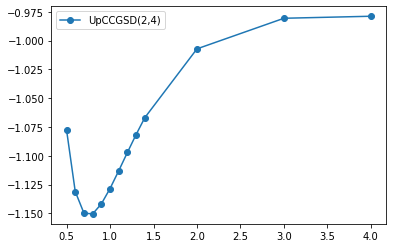

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(list(mra_vqe.keys()), list(mra_vqe.values()), marker="o", label="UpCCGSD(2,4)")
plt.legend()
plt.show()

For the case that psi4 is installed within your environment we can compute also the STO-3G energies in exact diagonalization (or with the VQE using the function above, but for this size the results will be the same, we compute both to illustrate that).
See the [paper](https://arxiv.org/abs/2008.02819) for the numbers close to the complete basis set limit (CBS), which is the exact solution with respect to electron correlation (FCI) and one-particle basis and larger MRA caluclations.
Set `no_compute=True` to avoid recomputing and save time.

In [6]:
no_compute = True
# in case you have psi4 installed you can compute the reference values here
if "psi4" in tq.quantumchemistry.INSTALLED_QCHEMISTRY_BACKENDS and not no_compute:
    def initialize_psi4_molecule(R):
        geomstring = "H 0.0 0.0 0.0\nH 0.0 0.0 {R}".format(R=R)
        molecule = tq.chemistry.Molecule(basis_set="sto-3g", geometry=geomstring, transformation=transformation)
        return molecule
    gbs_fci = {R:initialize_psi4_molecule(R).compute_energy("fci") for R in points}
    gbs_vqe = {R:compute_upgccsd_energy(initialize_psi4_molecule(R), silent=True) for R in points}
else:
    # otherwise, here they are
    gbs_vqe = {0.5: -1.05515979168155, 0.6: -1.1162859536932939, 0.7: -1.1361894250426225, 0.8: -1.1341473711383794, 0.9: -1.120560281221029, 1.0: -1.1011503300331484, 1.1: -1.0791929437201784,1.2: -1.0567407365989585,1.3: -1.0351862019508562,1.4: -1.015467897671673,2.0: -0.9486410371613808,3.0: -0.9336318373138941,4.0: -0.9331713618417009}
    gbs_fci = {0.5: -1.0551597946880178,0.6: -1.1162860069722242,0.7: -1.1361894540879063,0.8: -1.1341476666428472,0.9: -1.1205602812268745,1.0: -1.1011503301329566,1.1: -1.079192944852247,1.2: -1.05674074617943,1.3: -1.035186266306758,1.4: -1.0154682491653277,2.0: -0.9486411121296501,3.0: -0.933631844555985,4.0: -0.9331713618435854}
    
# close to CBS: FCI/cc-pVQZ calculation
# can be computed with the tequila psi4 interface in the same way as STO-3G (but takes time)
close_to_cbs = {0.5:-1.10338122, 0.6:-1.15531049,0.7:-1.1725277, 0.8:-1.17182109,0.9:-1.16178264,1.0:-1.14710242,1.1:-1.13045400,1.2:-1.11340654,1.3:-1.09689852,1.4:-1.08149165,2.0:-1.02143838,3.0:-1.00109047,4.0:-0.99995503}

Here are the comparisson plots. We use the notation (number_of_electrons, number_of_spin_orbitals) to indicate the sizes of the Hamiltonians.  
In this case we have minimal sizes (the smallest size where a treatment beyond mean-field is possible) which results in 4 spin-orbitals (and usually 4 qubits).

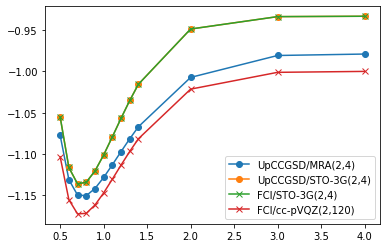

In [7]:
plt.figure()
plt.plot(list(mra_vqe.keys()), list(mra_vqe.values()), marker="o", label="UpCCGSD/MRA(2,4)")
plt.plot(list(gbs_vqe.keys()), list(gbs_vqe.values()), marker="o", label="UpCCGSD/STO-3G(2,4)")
plt.plot(list(gbs_fci.keys()), list(gbs_fci.values()), marker="x", label="FCI/STO-3G(2,4)")
plt.plot(list(close_to_cbs.keys()), list(close_to_cbs.values()), marker="x", label="FCI/cc-pVQZ(2,120)")

plt.legend()
plt.show()

To provide a complete picutre here are the values from the exact diagonalization of the Hamiltonian in MRA reprentation
(we initialize the `tequila` molecule, create the hamiltonian, export it as matrix and diagonalize with `numpy`).
The UpGCCSD is as good for MRA as it is for GBS (compared with exact diagonalization within those representations).

In [8]:
mra_diag = {R:numpy.linalg.eigvalsh(initialize_molecule(R).make_hamiltonian().to_matrix())[0] for R in points}    

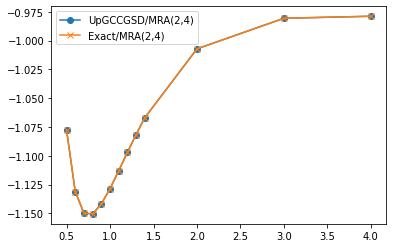

In [9]:
plt.figure()
plt.plot(list(mra_vqe.keys()), list(mra_vqe.values()), marker="o", label="UpGCCGSD/MRA(2,4)")
plt.plot(list(mra_diag.keys()), list(mra_vqe.values()), marker="x", label="Exact/MRA(2,4)")
plt.legend()
plt.show()